In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import f_oneway

import seaborn as sns
import gseapy as gp
import matplotlib.colors as mcolors

In [2]:
fdata = ad.read_h5ad("./RNA/Multitime_sorted.h5")
cdata = ad.read_h5ad("./RNA/Multitime.fixed.guide.h5")

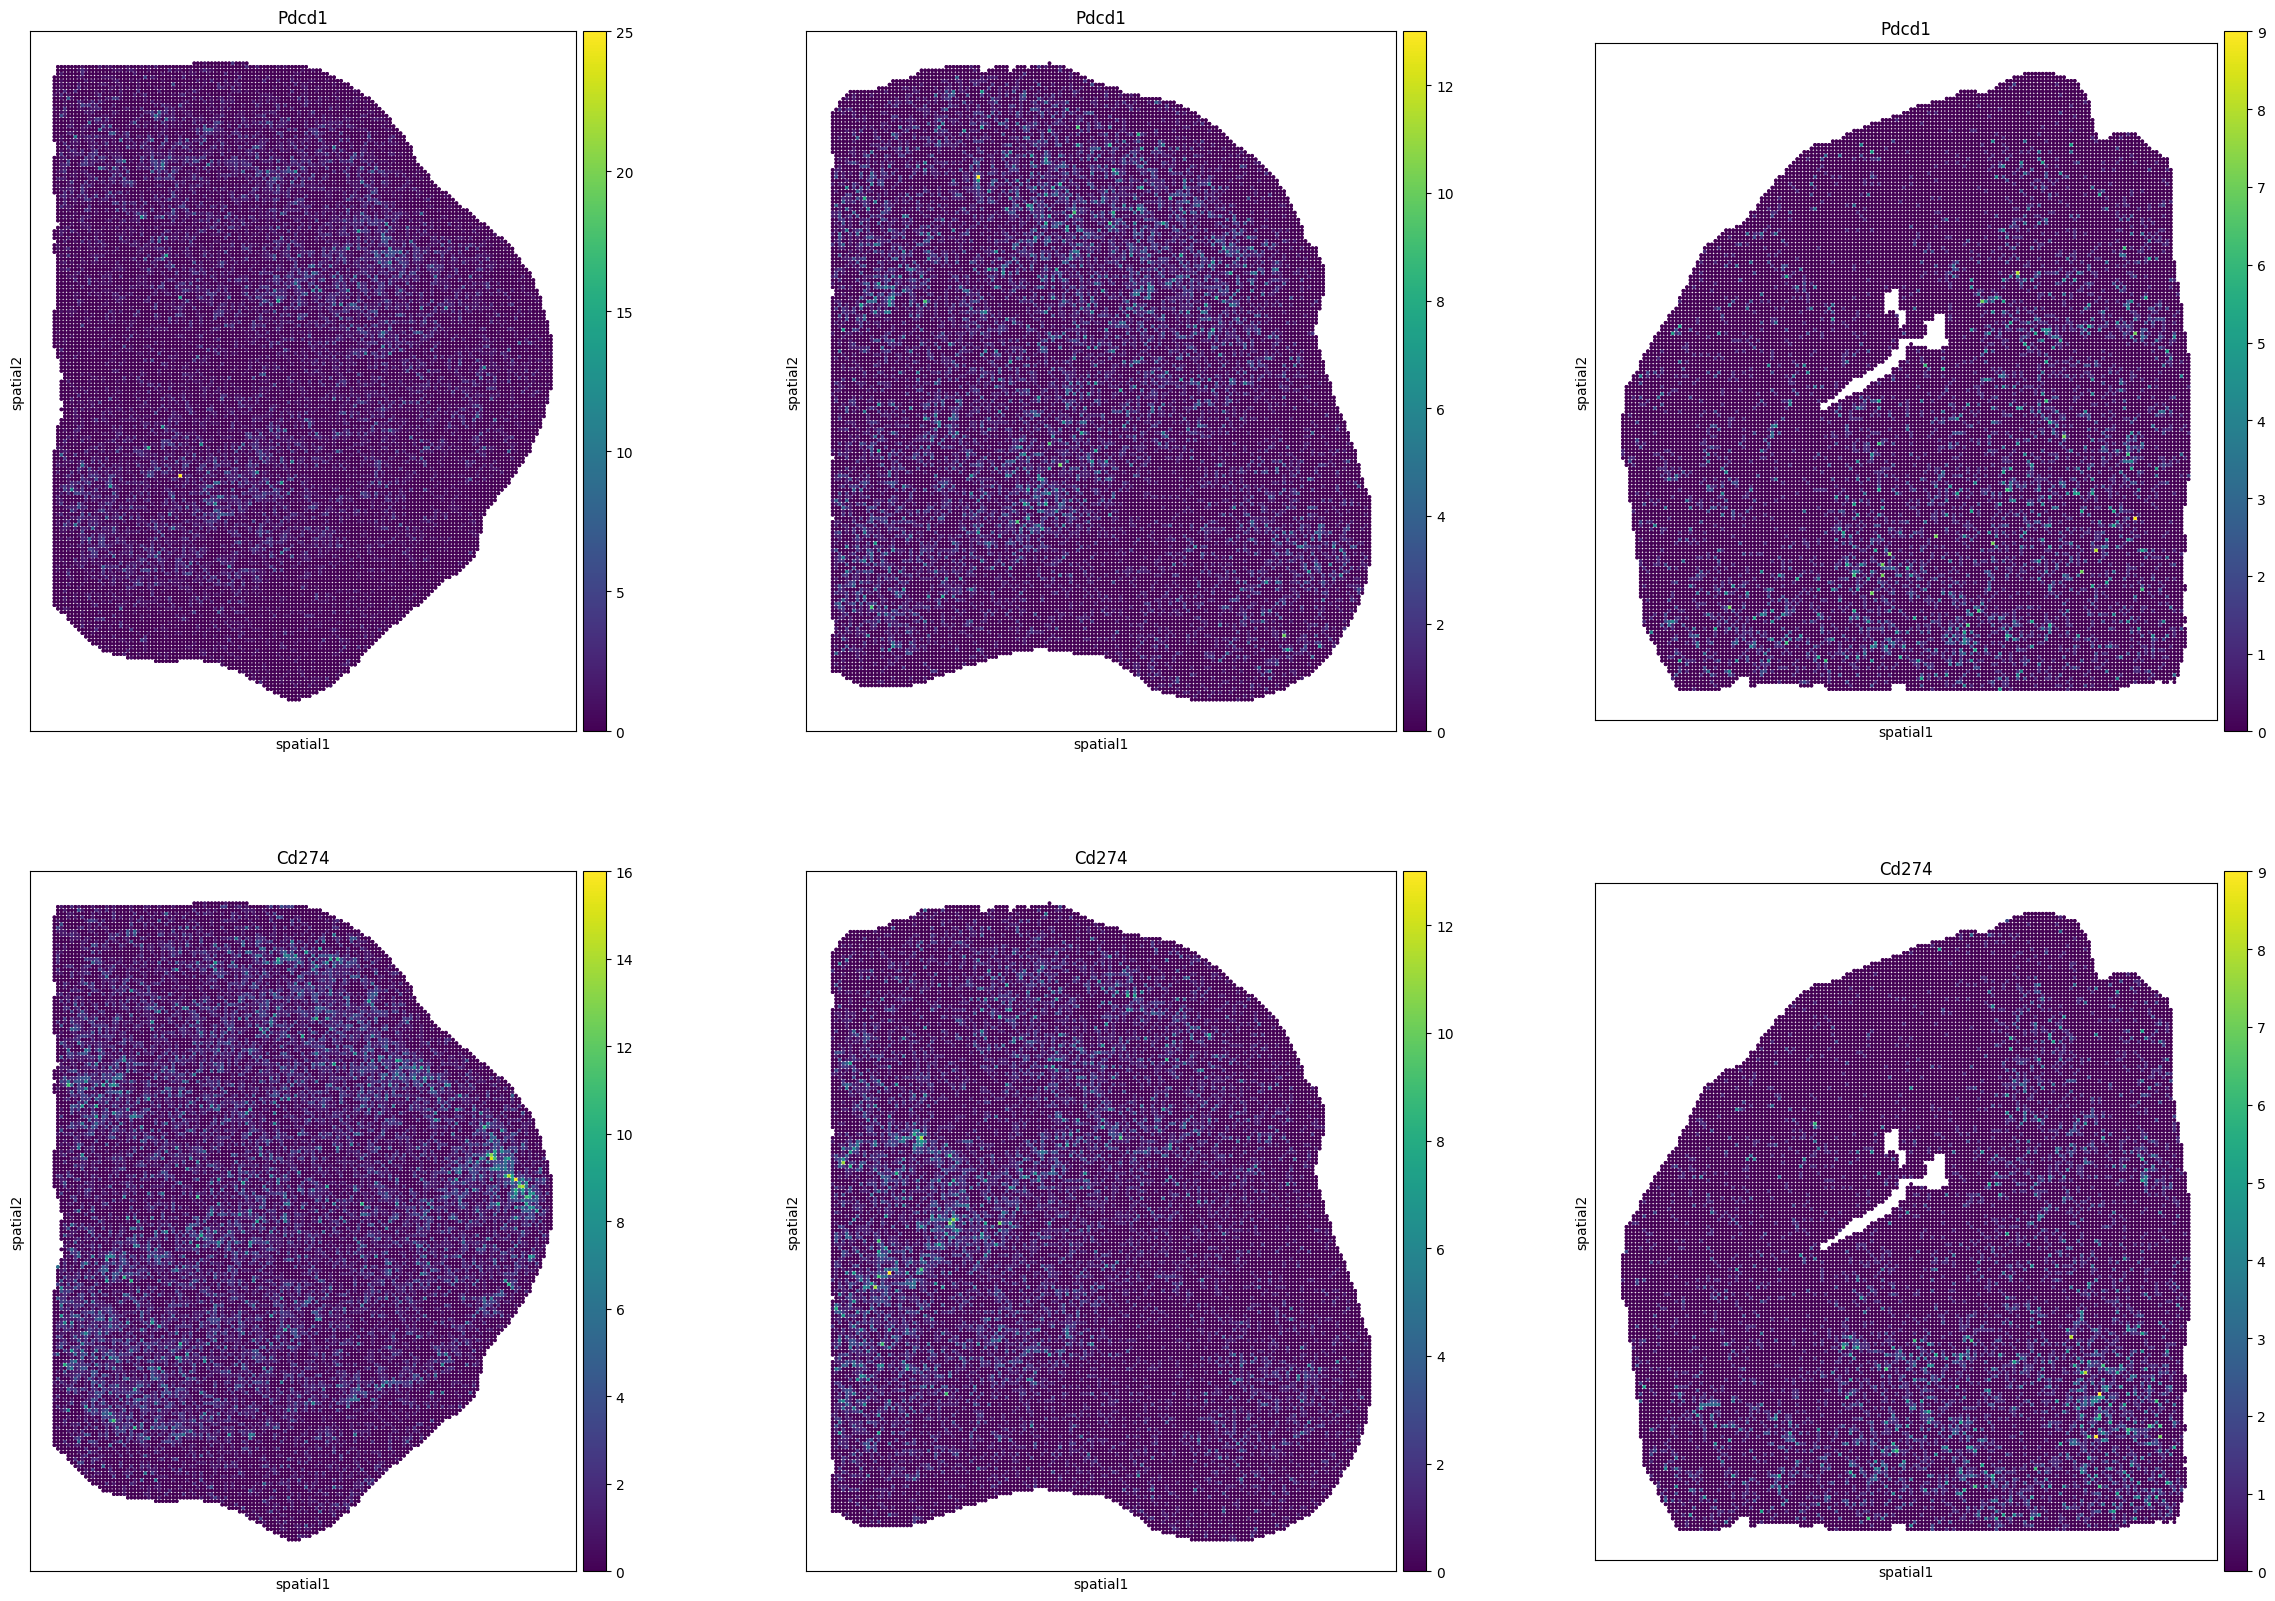

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
sq.pl.spatial_scatter(fdata[fdata.obs["time_point"] == "1"], layer="counts", color="Pdcd1", shape=None, size=10, library_id="spatial", ax=ax[0, 0])
sq.pl.spatial_scatter(fdata[fdata.obs["time_point"] == "2"], layer="counts", color="Pdcd1", shape=None, size=10, library_id="spatial", ax=ax[0, 1])
sq.pl.spatial_scatter(fdata[fdata.obs["time_point"] == "3"], layer="counts", color="Pdcd1", shape=None, size=10, library_id="spatial", ax=ax[0, 2])
sq.pl.spatial_scatter(fdata[fdata.obs["time_point"] == "1"], layer="counts", color="Cd274", shape=None, size=10, library_id="spatial", ax=ax[1, 0])
sq.pl.spatial_scatter(fdata[fdata.obs["time_point"] == "2"], layer="counts", color="Cd274", shape=None, size=10, library_id="spatial", ax=ax[1, 1])
sq.pl.spatial_scatter(fdata[fdata.obs["time_point"] == "3"], layer="counts", color="Cd274", shape=None, size=10, library_id="spatial", ax=ax[1, 2])

In [3]:
def shannon_index(counts):
    proportions = counts / np.sum(counts + 1)
    shannon_index = -np.sum(proportions * np.log2(proportions + 1e-9))
    return shannon_index

def total_count(counts):
    return np.sum(counts)

In [4]:
gene_data = cdata.X
s_indices = np.apply_along_axis(shannon_index, 1, gene_data)
t_counts = np.apply_along_axis(total_count, 1, gene_data)

In [5]:
cdata.obs["s_index"] = s_indices
cdata.obs["t_count"] = t_counts

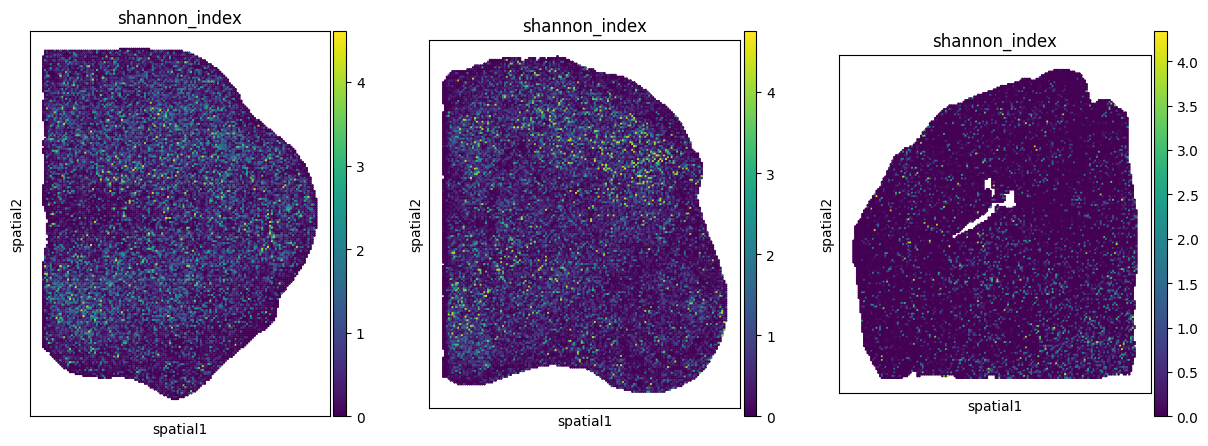

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sq.pl.spatial_scatter(cdata[cdata.obs["time_point"] == "1"], color="s_index", shape=None, size=2, title="shannon_index", spatial_key="spatial", ax=ax[0])
sq.pl.spatial_scatter(cdata[cdata.obs["time_point"] == "2"], color="s_index", shape=None, size=2, title="shannon_index", spatial_key="spatial", ax=ax[1])
sq.pl.spatial_scatter(cdata[cdata.obs["time_point"] == "3"], color="s_index", shape=None, size=2, title="shannon_index", spatial_key="spatial", ax=ax[2])

In [7]:
cdata_1 = cdata[cdata.obs["time_point"] == "1"]
cdata_2 = cdata[cdata.obs["time_point"] == "2"]
cdata_3 = cdata[cdata.obs["time_point"] == "3"]

fdata_1 = fdata[fdata.obs["time_point"] == "1"]
fdata_2 = fdata[fdata.obs["time_point"] == "2"]
fdata_3 = fdata[fdata.obs["time_point"] == "3"]

In [17]:
s_mu = np.mean(cdata_1.obs["s_index"])
s_d = np.std(cdata_1.obs["s_index"])
s_z = (cdata_1.obs["s_index"] - s_mu) / s_d

high_shannon_bin = [True if s else False for s in (s_z > 0.66)]
low_shannon_bin = [True if s else False for s in (s_z < 0)]
shannon_bin = [high * 2 + low * 1 for high, low in zip(high_shannon_bin, low_shannon_bin)]
cdata_1.obs["high_shannon"] = shannon_bin

fdata_1.obs["high_shannon"] = cdata_1.obs["high_shannon"].tolist()
fdata_1.obs["high_shannon"] = fdata_1.obs["high_shannon"].map({2: "high_shannon", 1: "low_shannon", 0: "medium_shannon"})
fdata_1.obs["high_shannon"] = fdata_1.obs["high_shannon"].astype("category")
sc.tl.rank_genes_groups(fdata_1, groupby="high_shannon", method="t-test")

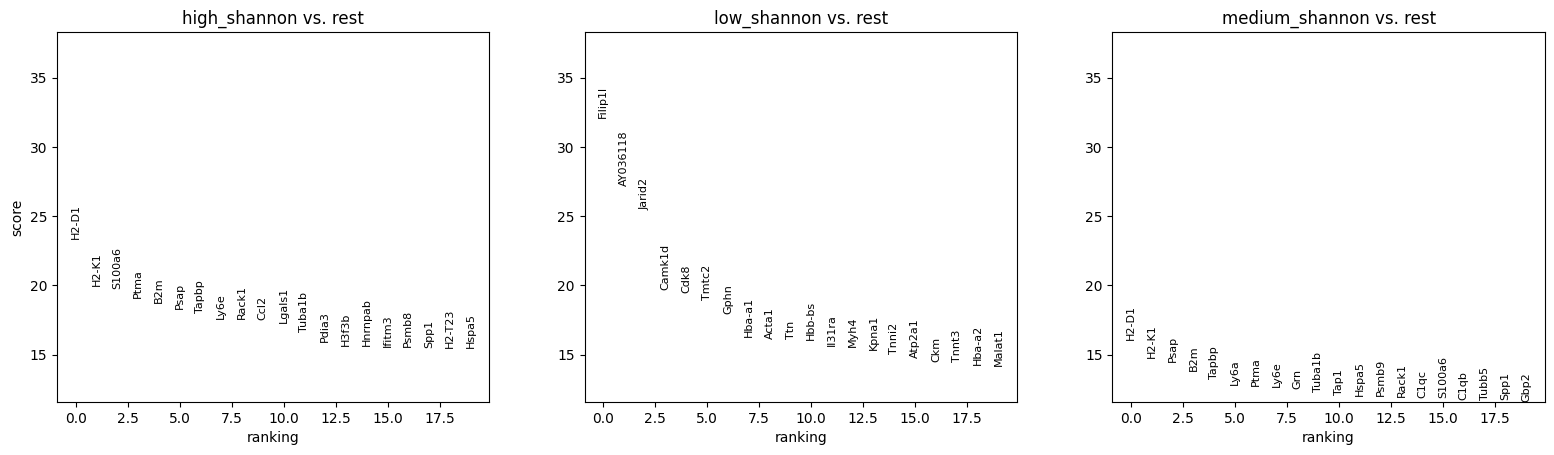

In [18]:
sc.pl.rank_genes_groups(fdata_1)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


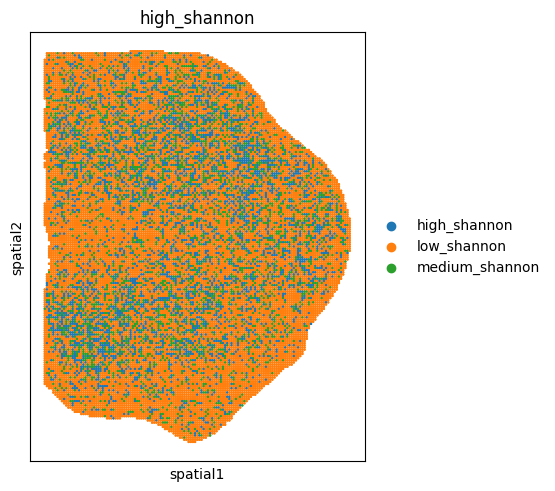

In [19]:
sq.pl.spatial_scatter(fdata_1, color="high_shannon", size=2, shape=None, library_id="spatial")

In [20]:
# proportion matrix for each gene and cluster
guide_cluster_counts = pd.DataFrame(cdata_1.X)
guide_cluster_counts.columns = cdata.var_names
guide_cluster_counts["cluster"] = cdata_1.obs["high_shannon"].tolist()

guide_total_counts = guide_cluster_counts.sum(axis=0)[:-1]
guide_cluster_proportions = guide_cluster_counts.groupby(["cluster"]).sum()
guide_cluster_proportions = guide_cluster_proportions.div(guide_total_counts, axis=1)
guide_cluster_proportions.index = guide_cluster_proportions.index.astype(int)
guide_cluster_proportions = guide_cluster_proportions.T.reindex(sorted(guide_cluster_proportions.index), axis=1)
for i in range(len(np.unique(cdata_1.obs["high_shannon"]))): guide_cluster_proportions[i] = guide_cluster_proportions.convert_dtypes().loc[:, i].astype(float).to_list()
ntc_guide_counts = guide_cluster_proportions.iloc[-1]
guide_cluster_proportions = guide_cluster_proportions - ntc_guide_counts

In [23]:
def p_value_to_significance(p_value):
    if p_value < 0.0001:
        return "****"
    elif p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "ns"
p_df = np.zeros((len(np.unique(cdata_1.obs["high_shannon"])), 33))
for ic in np.unique(cdata_1.obs["high_shannon"]):
    ntc_cnt_vec = cdata_1[cdata_1.obs["high_shannon"] == ic, "sgnon-targeting"].X.toarray().flatten()
    ntc_cnt_vec = ntc_cnt_vec / np.sum(cdata_1[:, "sgnon-targeting"].X)
    for ig, guide in enumerate(cdata_1.var_names[:-1]):
        guide_cnt_vec = cdata_1[cdata_1.obs["high_shannon"] == ic, guide].X.toarray().flatten()
        guide_cnt_vec = guide_cnt_vec / np.sum(cdata_1[:, guide].X)
        f_statistic, p_value = f_oneway(ntc_cnt_vec, guide_cnt_vec)
        p_df[ic, ig] = p_value
p_df = pd.DataFrame(p_df)
p_df = pd.concat([p_df, pd.DataFrame(np.ones((3, 1)))], axis=1).T
p_df = p_df.applymap(p_value_to_significance)
p_df.columns = np.unique(cdata_1.obs["high_shannon"])
p_df.index = cdata.var_names
p_df

/tmp/ipykernel_79492/3407248281.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p_df = p_df.applymap(p_value_to_significance)


0     1   2
sgAdrb2          ****    ns  ns
sgAqp3            ***    ns  ns
sgArntl          ****    ns  ns
sgCd44           ****  ****  ns
sgCd52             ns  ****  ns
sgCxcl16           ns   ***  ns
sgDdit3             *    ns  ns
sgErgic2          ***     *  ns
sgFbxo7            **    **  ns
sgFlot1            ns   ***  ns
sgGata3          ****  ****  ns
sgGlb1l2           ns   ***  ns
sgGpa33            ns    ns  ns
sgIkbip             *   ***  ns
sgKcna3          ****    ns  ns
sgKlrd1           ***    ns  ns
sgL3mbtl3         ***    ns  ns
sgMark3            **    ns  ns
sgMcoln1           ns  ****  ns
sgNmb            ****    ns  ns
sgPiezo1           ns  ****  ns
sgPomt1           ***    ns  ns
sgPpia             ns    ns  ns
sgS100a11        ****     *  ns
sgScamp4           ns    **  ns
sgSlc39a8        ****  ****  ns
sgSorl1            ns  ****  ns
sgSrgn             **     *  ns
sgTmem64           **    ns  ns
sgWipf1            ns  ****  ns
sgZc3h12a          **     *  ns
sgZhx2             ns   ***  ns
sgZscan12        ****     *  ns
sgnon-targeting    ns    ns  ns

In [31]:
guide_cluster_proportions.columns = ["medium_shannon", "low_shannon", "high_shannon"]

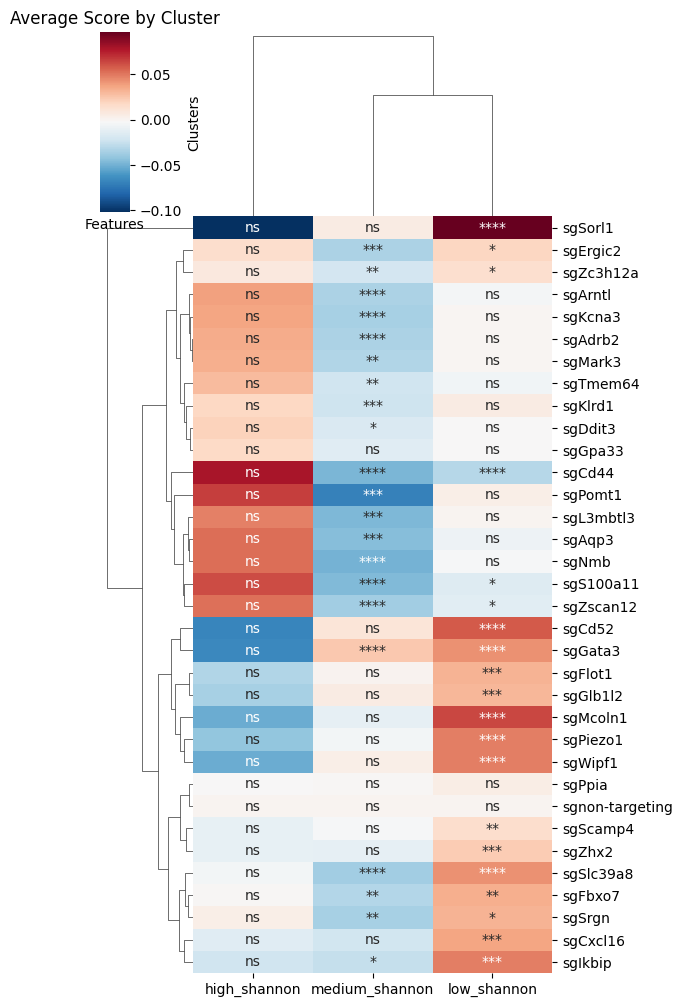

In [32]:
sns.clustermap(guide_cluster_proportions, annot=p_df, fmt="", cmap="RdBu_r", figsize=(6, 10))

plt.title('Average Score by Cluster')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

         Falling back to preprocessing with `sc.pp.pca` and default params.


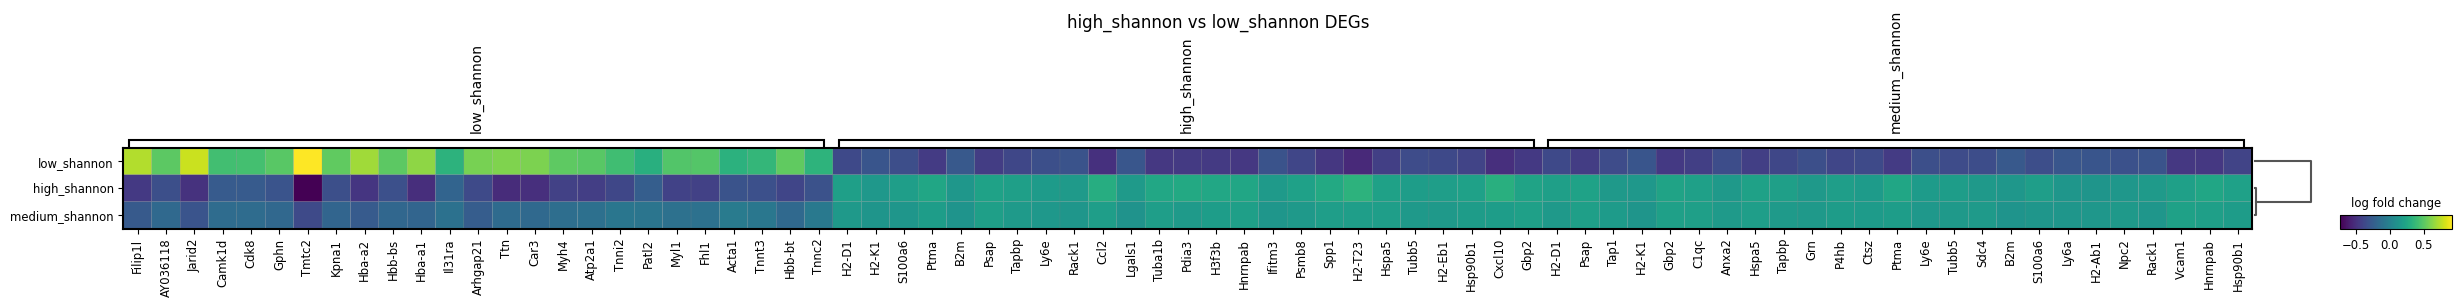

In [16]:
sc.pl.rank_genes_groups_matrixplot(fdata_1, n_genes=25, values_to_plot="logfoldchanges", title="high_shannon vs low_shannon DEGs")

In [112]:
pval_cutoff = 0.01
top_n = 50

result = fdata_1.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score
    })
    
    filtered_data = data[data['padj'] < pval_cutoff]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    
    top_genes['Cluster'] = group
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df.to_csv('DEG.csv', index=False, sep="\t")
top_genes_df

Gene  Log2FoldChange           padj      score       Cluster
0    Filip1l        0.460427  1.004098e-133  25.533148  high_shannon
1   AY036118        0.338896   1.524439e-95  21.495029  high_shannon
2     Jarid2        0.502454   4.054684e-82  19.866703  high_shannon
3      Tmtc2        0.738286   5.687274e-53  15.883450  high_shannon
4     Camk1d        0.267533   2.298522e-50  15.481578  high_shannon
..       ...             ...            ...        ...           ...
95     Psmb9        0.242894   1.582971e-40  13.844027   low_shannon
96     Lama5        0.255693   1.190104e-39  13.697361   low_shannon
97  Serpinh1        0.188533   1.409418e-39  13.673023   low_shannon
98  Dnase1l3        0.296545   2.813632e-39  13.631065   low_shannon
99      Cst3        0.154456   2.813632e-39  13.611137   low_shannon

[100 rows x 5 columns]

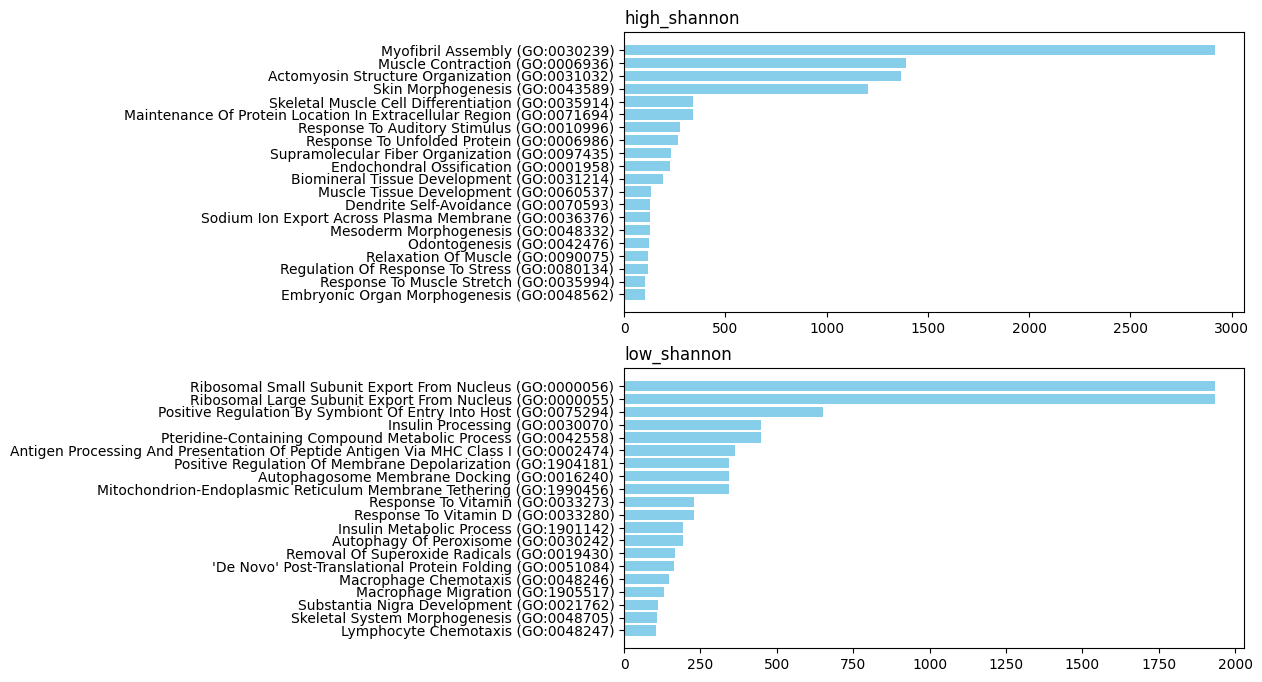

In [113]:
clusters = np.unique(fdata_1.obs["high_shannon"])
fig = plt.figure(figsize=(8, 8))
for i in range(2):
    ax = plt.subplot(2, 1, i+1)
    enr = pd.read_csv(f"./GO/Cluster_{i}.result", sep="\t")
    results = enr.sort_values(by='Combined Score', ascending=False).head(20)  # Select top 10 results for visualization

    ax.barh(results['Term'], results['Combined Score'], color='skyblue')

    plt.title(f"{clusters[i]}", loc="left")
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top

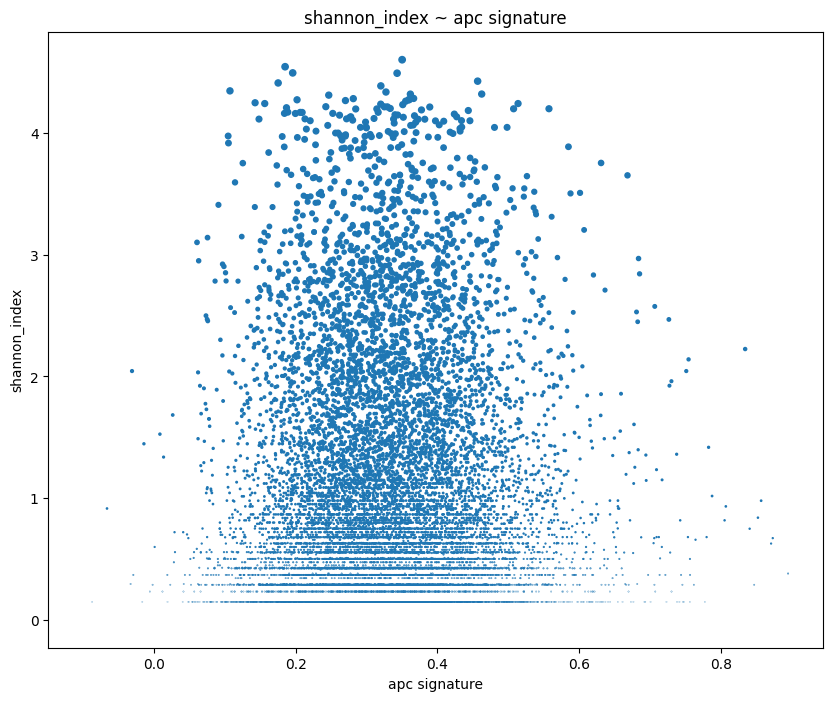

In [37]:
apc_signature_genes = ["Ptprc", "Cd14", "Itgam", "Itgax", "Trem2", "Fcgr4", "Ccr2", "Cd163", "Cd68", "Arg1", \
    "Adgre1", "Cd33", "Cd68", "C1qa", "Cd163",  "C1qb", "C1qc",  "Marco", "Cd81", "Ptprc", "Itgam", "Itgax", "Cd14", "Cd33", "Cd68", "Cd93", "Cd209d", "Ccl22", "Cd86", "Clec9a", "Clec10a", "Xcr1", "Lamp3"]

available_genes = [gene for gene in apc_signature_genes if gene in fdata_1.var_names]

missing_genes = set(apc_signature_genes) - set(available_genes)
if missing_genes:
    print(f"Warning: The following genes are not in the dataset and will be ignored: {missing_genes}")

sc.tl.score_genes(fdata_1, gene_list=available_genes, score_name=f"apc_score")
apc_signature_score = fdata_1.obs["apc_score"]

shannon = cdata[cdata.obs["time_point"] == "1"].obs["s_index"]

sizes = np.square(shannon)

plt.figure(figsize=(10, 8))
plt.scatter(apc_signature_score, shannon, s=sizes)
plt.title("shannon_index ~ apc signature")
plt.ylabel("shannon_index")
plt.xlabel("apc signature")
plt.show()

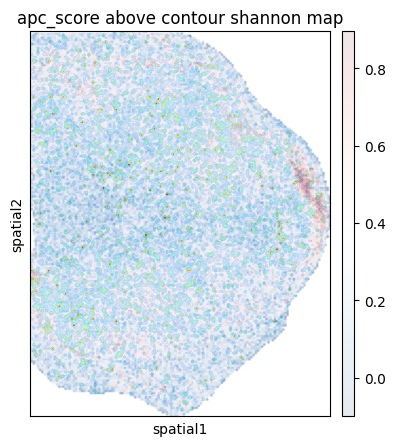

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

apo_bin = cdata_1.obs[f"s_index"]

hypo_coord = cdata_1.obsm['spatial']
coord_df = pd.DataFrame({
    'x_coord': hypo_coord[:, 0],
    'y_coord': hypo_coord[:, 1],
    'value': apo_bin
})
coord_df_piv = pd.pivot_table(coord_df, values="value", index="y_coord", columns="x_coord", aggfunc=np.mean)

z = coord_df_piv.values
y = coord_df_piv.index
x = coord_df_piv.columns

cmap = plt.get_cmap("jet")

new_cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, 100)))
new_cmap.colors[:, -1] = np.linspace(0, 0.8, new_cmap.N) 

cs = axs.contourf(x, y, z, 8, cmap=new_cmap)

expression = fdata_1.obs["apc_score"]
sizes = (expression - np.min(expression)) / (np.max(expression) - np.min(expression)) * 100
sizes = np.array(sizes, dtype=np.float32)
sq.pl.spatial_scatter(fdata_1, shape=None, color="apc_score", cmap="RdBu_r", library_id='expression', ax=axs, alpha=0.1)

plt.title("apc_score above contour shannon map")
plt.show()